<a href="https://colab.research.google.com/github/roshancharlie/Hindi-To-English-Transliteration-Model/blob/main/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
pip install keras

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 35.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 50.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.3 MB/s eta 0:00:0000:01
  Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 31.8 MB/s eta 0:00:0000:0100:01
     ━━━━━

In [57]:
pip install numpy


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install pandas


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#Importing the Libraries

In [63]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Data Preparation

In [149]:
train = pd.read_csv('train.csv')
for lines in train:
        print(lines)
print(train.columns)

train.head()


Unnamed: 0
hindi
english
Index(['Unnamed: 0', 'hindi', 'english'], dtype='object')


,Unnamed: 0,hindi,english
0,819069,अनाधिकृतपणे,anaadhikritapane
1,1160250,पॉडकास्टर,podcaster
2,810678,बेयंत,beyant
3,79522,बोझि,bojhee
4,1072591,बहानें,bahaanen


In [150]:
train = pd.read_csv('rom-table.csv')
for lines in train:
        print(lines)
print(train.columns)

train.head()

Unnamed: 0
tradHindi
newHindi
english
Index(['Unnamed: 0', 'tradHindi', 'newHindi', 'english'], dtype='object')


,Unnamed: 0,tradHindi,newHindi,english
0,1,अ,अ,a
1,2,आ,आ,ā
2,3,इ,िअ,i
3,4,ई,अी,ī
4,5,उ,अु,u


In [153]:
train['tradHindi'] = train['tradHindi'].astype(str)
train['newHindi'] = train['newHindi'].astype(str)
train['english'] = train['english'].astype(str)

In [154]:
train['tradHindi'] = train['tradHindi'].str.strip() # hindi has no caps
train['newHindi'] = train['newHindi'].str.strip() # hindi has no caps
train['english'] = train['english'].str.strip().str.lower()
for lines in train:
        print(lines)

Unnamed: 0
tradHindi
newHindi
english


In [155]:
train = train[~train['english'].str.contains('\.')]
train = train[~train['english'].str.contains(',')]
for lines in train:
        print(lines)

Unnamed: 0
tradHindi
newHindi
english


In [156]:
train.head()

,Unnamed: 0,tradHindi,newHindi,english
0,1,अ,अ,a
1,2,आ,आ,ā
2,3,इ,िअ,i
3,4,ई,अी,ī
4,5,उ,अु,u


In [157]:
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

train = train[train['english'].apply(isEnglish)]

In [159]:
sos = '^'
eos = '$'

train['english'] = sos + train['english'].astype(str) + eos

train.tail()

,Unnamed: 0,tradHindi,newHindi,english
57,58,None,स,^^sa$$
58,59,None,ब,^^ba$$
59,60,None,व,^^va$$
61,62,None,भ,^^bha$$
62,63,None,म,^^ma$$


In [161]:
hindi_text = train['newHindi']
english_text = train['english']

In [71]:
print('hindi text shape :',hindi_text.shape)
print(hindi_text[0])
print('english text shape :',english_text.shape)
print(english_text[0])

hindi text shape : (100000,)
अनाधिकृतपणे
english text shape : (100000,)
^anaadhikritapane$


In [72]:
train_hindi_text, val_hindi_text, train_english_text, val_english_text = train_test_split(hindi_text, english_text, test_size=0.2, random_state=42)

In [73]:
max_input_len = max([len(text) for text in hindi_text])
print(max_input_len)
max_target_len = max([len(text) for text in english_text])
print(max_target_len)

26
29


In [74]:
input_chars = sorted(list(set(''.join(hindi_text))))
print(input_chars)
target_chars = sorted(list(set(''.join(english_text))))
print(target_chars)

['ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'ळ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्']
['$', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [162]:
num_encoder_tokens = len(input_chars)
print(num_encoder_tokens)
num_decoder_tokens = len(target_chars)
print(num_encoder_tokens)

65
65


In [163]:
input_char_index = dict((char, i) for i, char in enumerate(input_chars))
print(input_char_index)
target_char_index = dict((char, i) for i, char in enumerate(target_chars))
print(target_char_index)

{'ँ': 0, 'ं': 1, 'ः': 2, 'अ': 3, 'आ': 4, 'इ': 5, 'ई': 6, 'उ': 7, 'ऊ': 8, 'ऋ': 9, 'ए': 10, 'ऐ': 11, 'ऑ': 12, 'ओ': 13, 'औ': 14, 'क': 15, 'ख': 16, 'ग': 17, 'घ': 18, 'ङ': 19, 'च': 20, 'छ': 21, 'ज': 22, 'झ': 23, 'ञ': 24, 'ट': 25, 'ठ': 26, 'ड': 27, 'ढ': 28, 'ण': 29, 'त': 30, 'थ': 31, 'द': 32, 'ध': 33, 'न': 34, 'प': 35, 'फ': 36, 'ब': 37, 'भ': 38, 'म': 39, 'य': 40, 'र': 41, 'ल': 42, 'ळ': 43, 'व': 44, 'श': 45, 'ष': 46, 'स': 47, 'ह': 48, '़': 49, 'ऽ': 50, 'ा': 51, 'ि': 52, 'ी': 53, 'ु': 54, 'ू': 55, 'ृ': 56, 'ॅ': 57, 'े': 58, 'ै': 59, 'ॉ': 60, 'ॊ': 61, 'ो': 62, 'ौ': 63, '्': 64}
{'$': 0, '^': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


In [164]:
encoder_input_data = np.zeros((len(train_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [165]:
for i, (input_text, target_text) in enumerate(zip(train_hindi_text, train_english_text)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            decoder_target_data[i, t - 1, target_char_index[char]] = 1

# Defining The Model

In [166]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [167]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Training

In [168]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
model_save_filename = "model.keras"
earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True
)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

# Print the summary of the model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 65)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None, 28)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 256),     │    329,728 │ input_layer_4[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    291,840 │ input_layer_5[0]… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 28)  │      7,196 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 628,764 (2.40 MB)

 Trainable params: 628,764 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [169]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=50,
          validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/50
  11/1000 ━━━━━━━━━━━━━━━━━━━━ 6:02 367ms/step - accuracy: 0.4589 - loss: 1.1033

In [93]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [94]:
pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


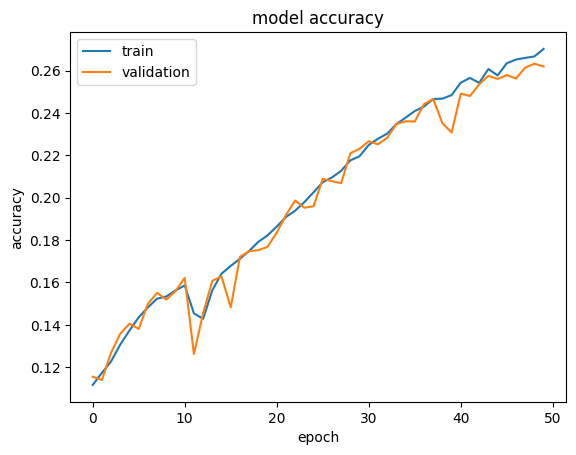

In [95]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

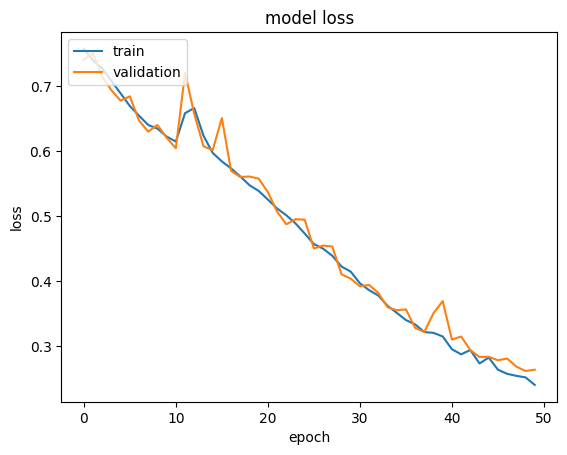

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Inference

In [97]:
model = load_model('model.keras')

In [98]:
val_encoder_input_data = np.zeros((len(val_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
val_decoder_input_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')
val_decoder_target_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [99]:
for i, (input_text, target_text) in enumerate(zip(val_hindi_text, val_english_text)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        val_decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            val_decoder_target_data[i, t - 1, target_char_index[char]] = 1

In [100]:
scores = model.evaluate([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.2621 - loss: 0.2592
Val loss: 0.2595711052417755
Val accuracy: 0.2625792920589447


In [101]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [102]:
reverse_input_char_index = dict((i, char) for char, i in input_char_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_char_index.items())

In [103]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_char_index['^']] = 1.0
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_chars[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '$' or len(decoded_sentence) > max_target_len):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

In [104]:
def predict_output(input_text):
    words = input_text.split(' ')
    transliterated_words = []
    for word in words:
        input_seq = np.zeros((1, max_input_len, num_encoder_tokens), dtype='float32')
        for t, char in enumerate(word):
            input_seq[0, t, input_char_index[char]] = 1
        decoded_word = decode_sequence(input_seq)
        transliterated_words.append(decoded_word.rstrip('$'))
    return ' '.join(transliterated_words)

In [105]:
text = 'शब्दावली'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: शब्दावली
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Transliterated English text: shabdavali


In [106]:
text = 'क्या है'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))
#kya haai

Hindi text: क्या है
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Transliterated English text: dia haai


In [107]:
text = 'रोशन'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: रोशन
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Transliterated English text: roshon


In [108]:
text = 'अनुवाद'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: अनुवाद
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Transliterated English text: anuvada


In [109]:
import os
print(os.getcwd())

/Users/mjere/Downloads/UROP


In [112]:
model.save('/Users/mjere/Downloads/UROP/model.keras')